In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
# Path to the dataset on kaggle website
#dataset = r"https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset"
dataset = r"https://www.kaggle.com/datasets/adityajn105/flickr8k"
WORKING_DIR='/kaggle/working'

In [ ]:
# Downloading the dataset
od.download(dataset)
#Kaggle creds - {"username":"nipungupta26","key":"7800b6f2327a2db633fe1d14f04280a5"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nipungupta26
Your Kaggle Key: ··········


100%|██████████| 1.04G/1.04G [00:08<00:00, 130MB/s]

In [ ]:
# Directory of the downloaded datasets in
#data_dir = r'coco-2017-dataset/coco2017'
data_dir = r'flickr8k/Images'

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Listing out the datasets
os.listdir(data_dir)

['123889082_d3751e0350.jpg',
 '3084380974_268a0f9236.jpg',
 '448916362_17f3f1d0e1.jpg',
 '2045562030_654ddea5e5.jpg',
 '211295363_49010ca38d.jpg',
 '1348113612_5bfc5f429e.jpg',
 '3036971334_78187a9570.jpg',
 '2107837987_ffecfc367a.jpg',
 '3429465163_fb8ac7ce7f.jpg',
 '3559781965_d4ec00e506.jpg',
 '2988244398_5da7012fce.jpg',
 '548751378_c657401312.jpg',
 '1528205014_1323aa9dfd.jpg',
 '3301754574_465af5bf6d.jpg',
 '3574627719_790325430e.jpg',
 '3307147971_5b3abf61f9.jpg',
 '2921094201_2ed70a7963.jpg',
 '3553476195_fb3747d7c1.jpg',
 '2747640247_b54bfa6886.jpg',
 '452416075_60b2bb5832.jpg',
 '3574244361_715ac347cd.jpg',
 '635444010_bd81c89ab7.jpg',
 '386160015_d4b31df68e.jpg',
 '556568556_bc5124dc8e.jpg',
 '96985174_31d4c6f06d.jpg',
 '827941668_2e4ac6cb39.jpg',
 '2934379210_4e399e3cac.jpg',
 '3223055565_68973f5d20.jpg',
 '1330645772_24f831ff8f.jpg',
 '3254817653_632e840423.jpg',
 '326585030_e1dcca2562.jpg',
 '2701895972_8605c4e038.jpg',
 '3319177177_130a72b8ae.jpg',
 '2192802444_b14bb87b9

In [ ]:
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from pathlib import Path

In [ ]:
path1 = Path(data_dir)

In [ ]:
path1.exists()

True

In [ ]:
model = VGG16()

553467096/553467096 [==============================] - 5s 0us/step


In [ ]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#extract features from image
features = {}
directory =  os.path.join(data_dir, 'train2017')

In [ ]:
for img_name in tqdm(os.listdir(data_dir)):
  img_path = data_dir + '/' + img_name
  image = load_img(img_path, target_size=(224, 224))
  image= img_to_array(image)
  image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
  image = preprocess_input(image)
  feature = model.predict(image, verbose=0)
  image_id = img_name.split('.')[0]
  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:

pickle.dump(features, open('features.pk1','wb' ))


In [ ]:
with open('features.pk1', 'rb') as f:
  features = pickle.load(f)



In [ ]:
with open(r'flickr8k/captions.txt', 'r') as f:
  next(f)
  captions_doc = f.read()



In [ ]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = ' '.join(caption)
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

**Preprocess Text Data**

In [ ]:
#Now we will preprocess the captions
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      #Take one caption at a time
      caption = captions[i]
      #Preprocessing steps
      #Convert to lower case
      caption = caption.lower()
      #delete digit, special characters
      caption = caption.replace('[^A-Za-z]', '')
      # Remove additional spaces
      caption = caption.replace('\s+', ' ')
      # Add start and end tags to the caption
      caption = 'startseq ' + ' '.join(word for word in caption.split() if len(word)>1) + ' endseq'
      captions[i] = caption

In [ ]:
# Before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# After preprocess of text
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [ ]:
# toeknize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8483

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
# Train test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
split
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids sessions crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence into X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode the output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
  if n == batch.size:
    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    yield [X1, X2], y
    X1, X2, y = list(), list(), list()
    n = 0 

**Model Creation**

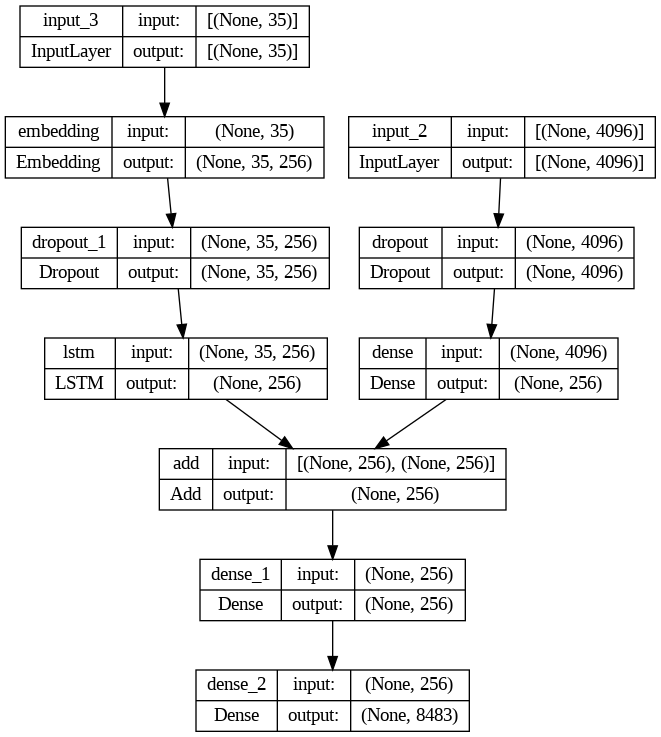

In [ ]:
# encoder model
# image feature model
inputs1 = Input(shape = (4096, ))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# Train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for one epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

**Generate captions for the image**

In [ ]:
def idx_to_word(integer, token):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for generation process
  in_text = '<start>'
  # iterate over the max length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([int_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    yhat = model.predict([image, sequence], verbose=0)
    # get index with high probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    in_text += " " + word
    # stop if we reach end tag
    if word == 'endseq':
      break
  return in_text





In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)


# calculate BLEU score
print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')


**Visualize the results**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
  #load the image
  
  image_id = image_name.split('.')[0]
  img_path = os.path.join(BASE_DIR, "Images", image_name)
  image = image.open(img_path)
  captions = mapping[image_id]
  print('------------Actual-------------')
  for caption in captions:
    print(caption)
  #predict the caption
  y_pred = predict_caption(model,features[image_id], tokenizer, max_length)
  print('-----------Predicted-----------')
  print(y_pred)
  plt.imshow(image)

In [ ]:
image_name = "1001773457_577c3a7d70.jpg"
generate_caption(image_name)